In [55]:
import numpy
import networkx as nx
import osmnx as ox
import os
import glob
from infomap import Infomap
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt

# Read data

In [ ]:
# Read graphml files for cities
city_graph_dict = {}

files = glob.glob('../input/data/*.graphml')
for file in files:
    filename = os.path.basename(file)
    city = filename.split('_')[0]
    graph = ox.io.load_graphml(file)
    city_graph_dict[city] = graph

In [18]:
city_graph_dict

{'glasgow': <networkx.classes.multidigraph.MultiDiGraph at 0x32abe7250>,
 'dubai': <networkx.classes.multidigraph.MultiDiGraph at 0x3295f3c50>,
 'charlotte': <networkx.classes.multidigraph.MultiDiGraph at 0x32ba99590>,
 'copenhagen': <networkx.classes.multidigraph.MultiDiGraph at 0x32bd77f70>,
 'denver': <networkx.classes.multidigraph.MultiDiGraph at 0x32c302030>,
 'dublin': <networkx.classes.multidigraph.MultiDiGraph at 0x32bf1ce10>,
 'buenos': <networkx.classes.multidigraph.MultiDiGraph at 0x32d258c30>,
 'chicago': <networkx.classes.multidigraph.MultiDiGraph at 0x32cdf87d0>,
 'caracas': <networkx.classes.multidigraph.MultiDiGraph at 0x32c49fd90>,
 'dallas': <networkx.classes.multidigraph.MultiDiGraph at 0x32cc68910>}

In [45]:
# Convert graphs to undirected
city_graph_dict_undirected = {}
for city, G in city_graph_dict.items():
    city_graph_dict_undirected[city] = G.to_undirected()

# Run infomap and analyze communities

## Directed graph

In [ ]:
# Run infomap on each graph and store the communities
city_communities_dict = {}
for city, G in tqdm(city_graph_dict.items()):
    # # Choose flags explicitly
    # im = Infomap("--two-level --num-trials 50")
    # If your graph is directed, use:
    im = Infomap("--directed --two-level --num-trials 50")
    
    # Map NetworkX node labels to integers (REQUIRED)
    node_to_id = {node: i for i, node in enumerate(G.nodes())}
    id_to_node = {i: node for node, i in node_to_id.items()}

    # Add edges
    for u, v, data in G.edges(data=True):
        w = data.get("weight", 1.0)
        im.addLink(node_to_id[u], node_to_id[v], w)

    # Run Infomap
    im.run()

    # Extract communities
    communities = {}
    for node in im.nodes:
        original_node = id_to_node[node.node_id]
        communities[original_node] = node.module_id

    city_communities_dict[city] = communities
    nx.set_node_attributes(G, communities, "infomap")

# communities: dict {node -> community_id}

100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


## Undirected graph

In [46]:
# Run infomap on each graph and store the communities
city_communities_undirected_dict = {}
for city, G in tqdm(city_graph_dict_undirected.items()):
    # Choose flags explicitly
    im = Infomap("--two-level --num-trials 50")
    # If your graph is directed, use:
    # im = Infomap("--directed --two-level --num-trials 50")
    
    # Map NetworkX node labels to integers (REQUIRED)
    node_to_id = {node: i for i, node in enumerate(G.nodes())}
    id_to_node = {i: node for node, i in node_to_id.items()}

    # Add edges
    for u, v, data in G.edges(data=True):
        w = data.get("weight", 1.0)
        im.addLink(node_to_id[u], node_to_id[v], w)

    # Run Infomap
    im.run()

    # Extract communities
    communities = {}
    for node in im.nodes:
        original_node = id_to_node[node.node_id]
        communities[original_node] = node.module_id

    city_communities_undirected_dict[city] = communities
    nx.set_node_attributes(G, communities, "infomap")

# communities: dict {node -> community_id}

100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


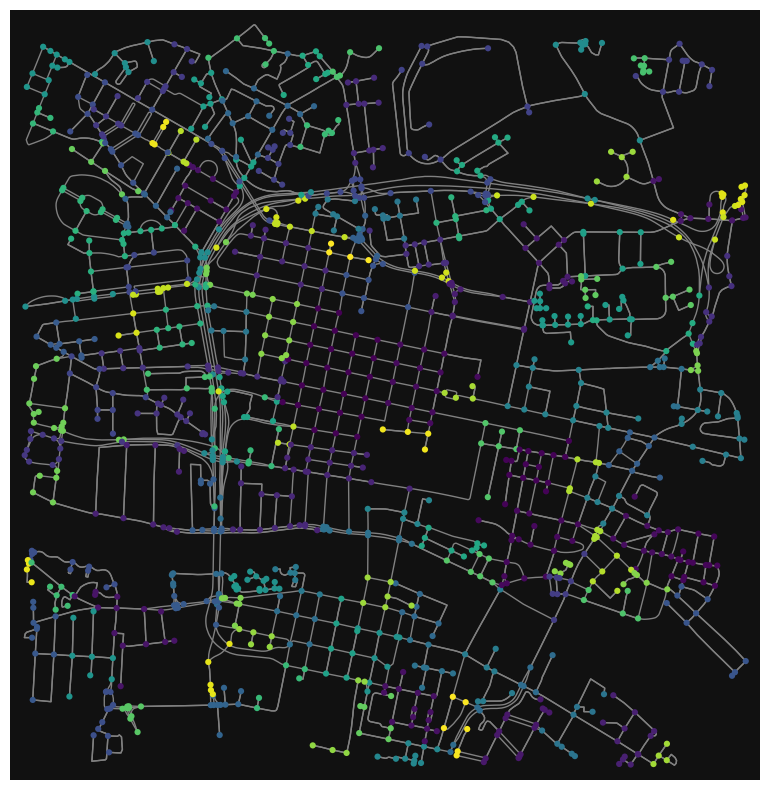

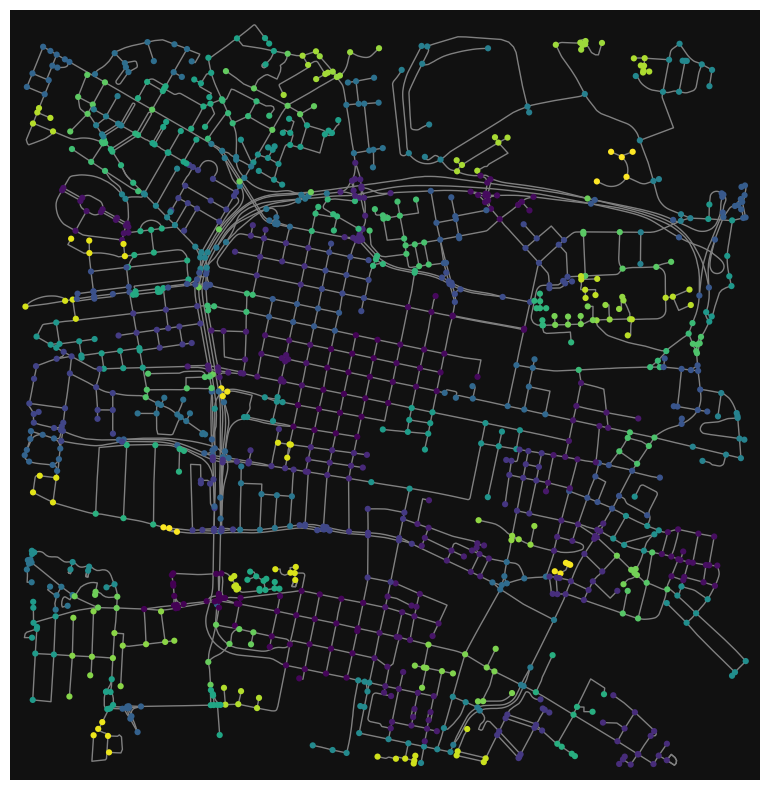

In [47]:
# Visualize infomap communities for each city using osmnx
# Define a color map
cmap = plt.get_cmap('tab20')

for city, G in city_graph_dict.items():
    fig, ax = ox.plot_graph(G, node_color=list(nx.get_node_attributes(G, 'infomap').values()), node_size=20, edge_color='gray', figsize=(10,10))
    fig, ax = ox.plot_graph(city_graph_dict_undirected[city], node_color=list(nx.get_node_attributes(city_graph_dict_undirected[city], 'infomap').values()), node_size=20, edge_color='gray', figsize=(10,10))
    break

In [52]:
max(city_communities_dict['glasgow'].values())

152

In [51]:
max(city_communities_undirected_dict['glasgow'].values())

138

In [64]:
def plot_infomap_edges(G, comm, axes, black="#eeeeee", cmap_name="tab20"):
    """
    G: osmnx graph (usually MultiDiGraph)
    comm: dict {node_id: community_id}
    """

    # stable list of community ids and a color map for them
    comm_ids = sorted(set(comm.values()))
    cmap = plt.get_cmap(cmap_name, max(len(comm_ids), 1))
    comm_to_color = {cid: mpl.colors.to_hex(cmap(i)) for i, cid in enumerate(comm_ids)}

    edge_colors = []
    for u, v, k, data in G.edges(keys=True, data=True):
        cu = comm.get(u, None)
        cv = comm.get(v, None)

        if (cu is not None) and (cv is not None) and (cu == cv):
            edge_colors.append(comm_to_color[cu])
        else:
            edge_colors.append(black)

    fig, ax = ox.plot_graph(
        G,
        node_size=0,                 # streets only
        edge_color=edge_colors,
        edge_linewidth=1.2,
        edge_alpha=1.0,
        bgcolor="white",
        show=False,
        close=False,
        ax=axes,
    )

    return fig, ax

# usage:
# fig, ax = plot_infomap_edges(G, communities_dict)
# plt.show()


Text(0.5, 0.98, 'Infomap Communities in Dallas')

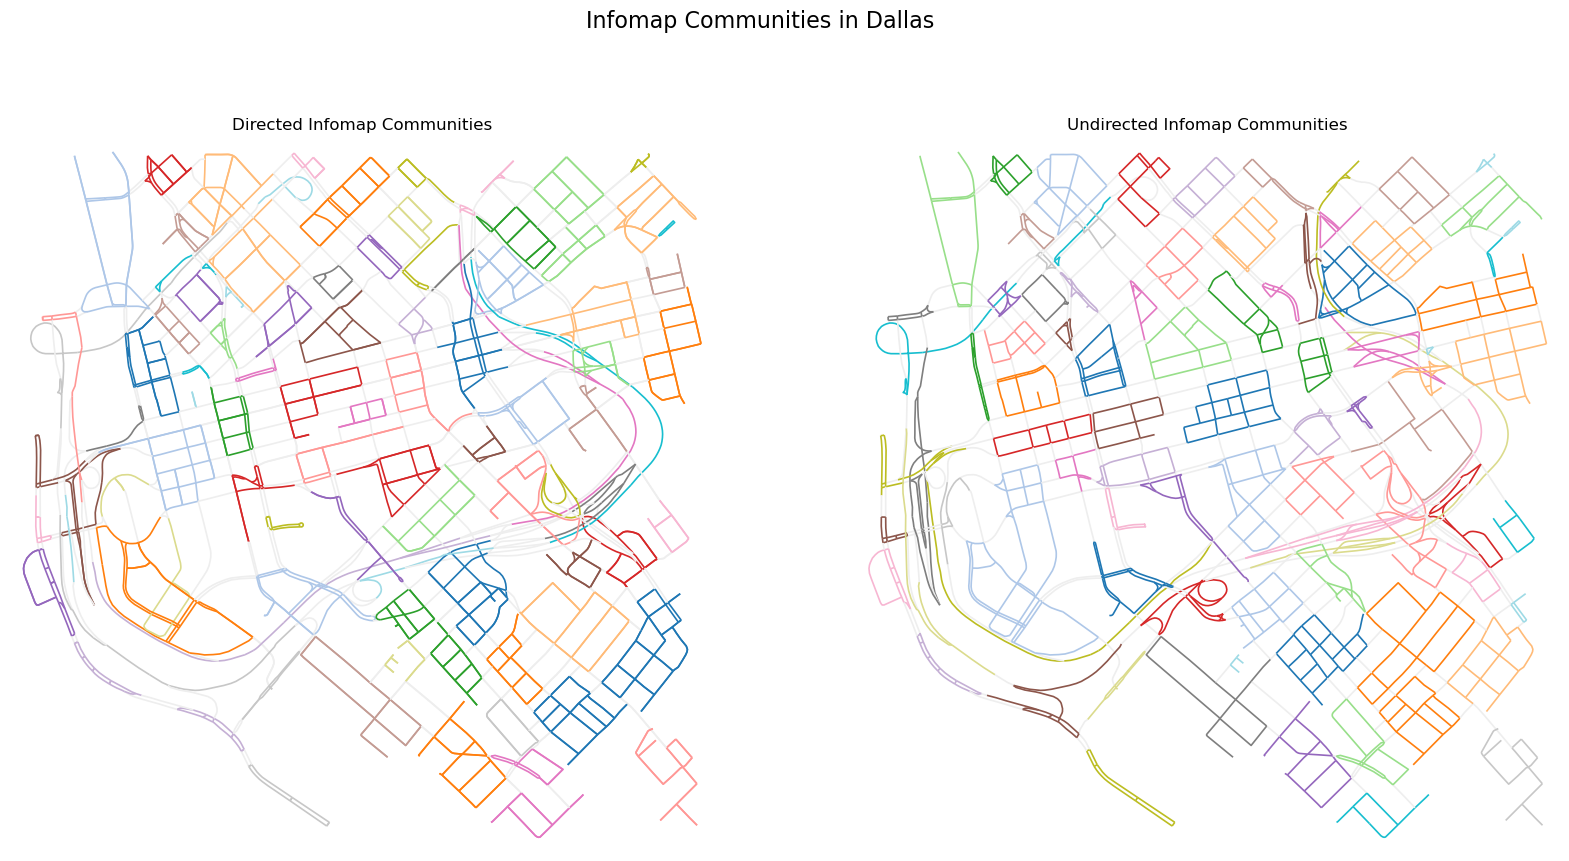

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))

city='dallas'

plot_infomap_edges(city_graph_dict[city], city_communities_dict[city], axes[0])
plot_infomap_edges(city_graph_dict_undirected[city], city_communities_undirected_dict[city], axes[1])

axes[0].set_title('Directed Infomap Communities')
axes[1].set_title('Undirected Infomap Communities')

plt.suptitle(f'Infomap Communities in {city.capitalize()}', fontsize=16)